# Enron Emails Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

import gensim
from gensim import corpora
from gensim import models
from gensim.models import LdaModel
from gensim.models import LsiModel
import pyLDAvis
import warnings
warnings.filterwarnings("ignore")

In [2]:
stopwords = stopwords.words('english')
stopwords += ['would', 'http', 'com', 'cc', 'need', 'also', 'www', 'get', 'like', 'said', 'forwarded', 'mail', 'email']

In [3]:
pd.set_option('display.max_colwidth', -1)

In [4]:
df = pd.read_csv('data/enron_test.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      1000 non-null   object
 1   From      1000 non-null   object
 2   To        995 non-null    object
 3   Subject   698 non-null    object
 4   content   1000 non-null   object
 5   new_date  1000 non-null   object
dtypes: object(6)
memory usage: 47.0+ KB


In [6]:
df = df.drop_duplicates()

In [7]:
df.shape

(664, 6)

## Exploratory Data Analysis

### When do people send emails?

In [8]:
# pre-precess dates
df['year'] = df['Date'].apply(lambda x: x.split(' ')[3])
df['month'] = df['Date'].apply(lambda x: x.split(' ')[2])
df['day_of_week'] = df['Date'].apply(lambda x: x.split(',')[0])
df['hour'] = df['Date'].apply(lambda x: x.split(' ')[4][:2])

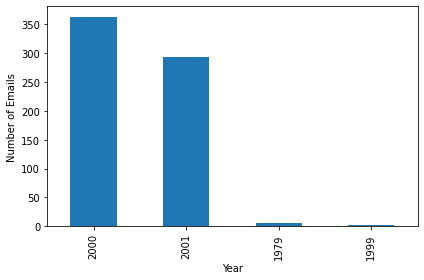

In [9]:
df['year'].value_counts().plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of Emails')
plt.tight_layout()
plt.savefig('img/year.png')

In [10]:
df = df[(df['year'] == '2000') | (df['year'] == '2001')]

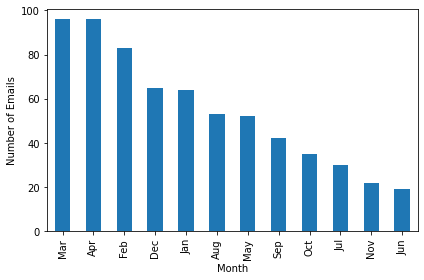

In [11]:
df['month'].value_counts().plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Number of Emails')
plt.tight_layout()
plt.savefig('img/month.png')

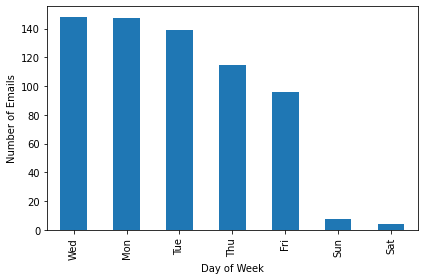

In [12]:
df['day_of_week'].value_counts().plot(kind='bar')
plt.xlabel('Day of Week')
plt.ylabel('Number of Emails')
plt.tight_layout()
plt.savefig('img/day_week.png')

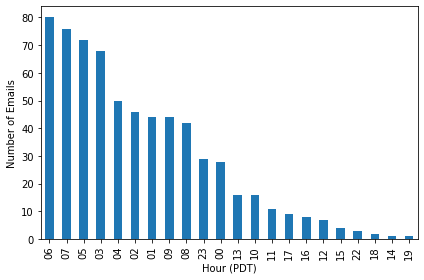

In [13]:
df['hour'].value_counts().plot(kind='bar')
plt.xlabel('Hour (PDT)')
plt.ylabel('Number of Emails')
plt.tight_layout()
plt.savefig('img/hour.png')

### Who sends the most emails?

In [14]:
df['sender'] = df['From'].apply(lambda x: x.split('\'')[1])

In [15]:
df['sender'].value_counts()[:5]

phillip.allen@enron.com      603
critical.notice@enron.com    5  
ina.rangel@enron.com         4  
ei_editor@ftenergy.com       2  
sarah.novosel@enron.com      2  
Name: sender, dtype: int64

In [16]:
df['recipient'] = df['To'].apply(lambda x: x.split('\'')[1] if type(x) == str else 'N/A')

In [17]:
# one sent to mulitple people
df['recipient'].value_counts()[:5]

jsmith@austintx.com           40
stagecoachmama@hotmail.com    40
ina.rangel@enron.com          37
pallen70@hotmail.com          27
keith.holst@enron.com         24
Name: recipient, dtype: int64

In [18]:
df_phillip_to_ina = df[(df['sender'] == 'phillip.allen@enron.com') & (df['recipient'] == 'ina.rangel@enron.com')]

In [ ]:
for i in df_phillip_to_ina['content']:
    print('#' * 30)
    print(i)

Seems like most of the emails sent by Phillip to Ina are forwarded messages.

In [20]:
df_phillip_to_phillip = df[(df['sender'] == 'phillip.allen@enron.com') & (df['recipient'] == 'pallen70@hotmail.com')]

In [ ]:
for i in df_phillip_to_phillip['content']:
    print('#' * 30)
    print(i)

In [22]:
df_phillip_to_stage = df[(df['sender'] == 'phillip.allen@enron.com') & (df['recipient'] == 'stagecoachmama@hotmail.com')]

In [ ]:
for i in df_phillip_to_stage['content']:
    print('#' * 30)
    print(i)

In [24]:
df_phillip_to_jsmith = df[(df['sender'] == 'phillip.allen@enron.com') & (df['recipient'] == 'keith.holst@enron.com')]

In [ ]:
for i in df_phillip_to_jsmith['content']:
    print('#' * 30)
    print(i)

In [26]:
def preprocess_content(row):
    output = ''
    # remove punctuations
    lines = row.split('\n')
    for line in lines:
        if ':' not in line:
            for letter in line:
                output += re.sub(r'[\W\d^_]', ' ', letter)
    
    # remove stopwords
    output = word_tokenize(output)
    output = [word for word in output if word.lower() not in stopwords]
    sentence = ' '.join(output)
    
    # remove proper nouns
    tagged_sentence = nltk.tag.pos_tag(sentence.split())
    edited_sentence = [word for word,tag in tagged_sentence if tag != 'NNP' and tag != 'NNPS']
    clean_output = ' '.join(edited_sentence).lower()
    
    return clean_output

In [27]:
df['clean_content'] = df['content'].apply(preprocess_content)

In [28]:
df['clean_content'].head()

0    forecast                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
1    traveling business meeting takes fun trip prepare presentation suggest holding business plan meetings take trip without formal business meetings even try honest opinions whether trip even desired necessary far business meetings think productive try stimulate discussions across different groups working often presenter speaks others quiet waiting turn meetings might better held round table discussion format suggestion go golf rent ski boat jet ski flying somewhere takes much time
2    test successful way

## Topic Modeling with LDA

### Can we group emails into different topics?

In [29]:
tokens_list = [line.split() for line in df['clean_content'].tolist()]

In [30]:
#remove words that appear only once
from collections import defaultdict
frequency = defaultdict(int)

for tokens in tokens_list:
    for token in tokens:
        frequency[token] += 1
           
tokens_list = [[token for token in tokens if frequency[token]>1 and len(token) > 3 and token.isalpha()]
              for tokens in tokens_list]

In [91]:
{k: v for k, v in sorted(frequency.items(), key=lambda item: item[1], reverse=True)[:10]}

{'gas': 165,
 'power': 130,
 'time': 127,
 'project': 117,
 'new': 104,
 'cost': 102,
 'loan': 101,
 'market': 100,
 'one': 99,
 'call': 95}

In [33]:
# generate token dictionary class
dictionary = corpora.Dictionary(tokens_list)

Dictionary(2856 unique tokens: ['forecast', 'across', 'better', 'boat', 'business']...)


In [34]:
# generate a unique token list 
sort_token = sorted(dictionary.items(),key=lambda k:k[0], reverse = False)
unique_token = [token for (ID,token) in sort_token]

In [35]:
# build a corpus
corpus = [dictionary.doc2bow(tokens) for tokens in tokens_list]  
# (0, 1) == first word in unique token list appeared 1 time

In [36]:
df['corpus'] = corpus

In [78]:
# fit lda model
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=4, passes=25) 

In [81]:
topic_list = lda.print_topics(num_topics=4, num_words=10)

In [82]:
topic_list

[(0,
  '0.014*"loan" + 0.014*"cost" + 0.011*"land" + 0.011*"loans" + 0.010*"construction" + 0.010*"costs" + 0.008*"value" + 0.007*"equity" + 0.007*"basis" + 0.006*"fees"'),
 (1,
  '0.014*"power" + 0.013*"prices" + 0.008*"price" + 0.007*"week" + 0.007*"market" + 0.006*"time" + 0.006*"today" + 0.005*"call" + 0.005*"traders" + 0.005*"trades"'),
 (2,
  '0.011*"project" + 0.005*"market" + 0.005*"time" + 0.005*"send" + 0.005*"loan" + 0.005*"know" + 0.004*"cash" + 0.004*"work" + 0.004*"back" + 0.004*"property"'),
 (3,
  '0.010*"information" + 0.008*"meeting" + 0.008*"position" + 0.007*"call" + 0.007*"desk" + 0.006*"please" + 0.006*"access" + 0.005*"date" + 0.005*"help" + 0.005*"book"')]

In [83]:
topic_words = []
for topic in topic_list:
    words = []
    line = topic[1].split('\"')
    for i, j in enumerate(line):
        if i % 2 != 0:
            words.append(j)
            print(j)
    print('---')
    topic_words.append(words)

loan
cost
land
loans
construction
costs
value
equity
basis
fees
---
power
prices
price
week
market
time
today
call
traders
trades
---
project
market
time
send
loan
know
cash
work
back
property
---
information
meeting
position
call
desk
please
access
date
help
book
---


In [84]:
def classify(row):
    topic = max(lda[row],key=lambda item:item[1])[0] 
    return topic

In [85]:
df['topic'] = df['corpus'].apply(classify)

In [86]:
df['month_year'] = df['month'] + ' ' + df['year']
df['month_year'] = pd.to_datetime(df['month_year'])

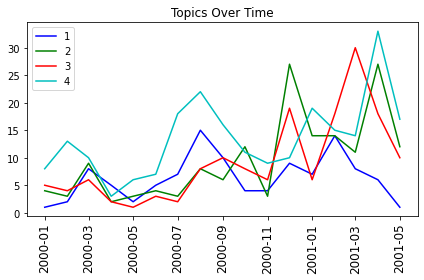

In [89]:
df_topic = df.groupby(['month_year', 'topic']).count().reset_index()
color = ['b', 'g', 'r', 'c']
for i in range(1, 5):
    plt.plot('month_year', 'corpus', data=df_topic[df_topic['topic'] == i - 1], color=color[i - 1])
plt.title('Topics Over Time')
plt.xticks(fontsize=12, rotation=90)
plt.legend(range(1, 5))
plt.tight_layout()
plt.savefig('img/topic.png')
plt.show()